In [1]:
import warnings
import numpy as np
import pandas as pd
from math import floor, ceil
import os.path as op
from typing import List, Any, Callable, Literal, Optional, Union
from pandas.api.types import is_object_dtype
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu
from peregrin.scripts import PlotParams
import seaborn as sns
from itertools import combinations
import altair as alt
import plotly.graph_objects as go
from datetime import date





def _pick_encoding(path, encodings=("utf-8", "cp1252", "latin1", "iso8859_15")):
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False if enc != "utf-8" else True)
        except UnicodeDecodeError:
            continue

def _has_strings(s: pd.Series) -> bool:
    # pandas "string" dtype (pyarrow/python)
    if isinstance(s.dtype, pd.StringDtype):
        return s.notna().any()
    # categorical of strings?
    if isinstance(s.dtype, pd.CategoricalDtype):
        return isinstance(s.dtype.categories.dtype, pd.StringDtype) and s.notna().any()
    # numeric, datetime, bool, etc.
    if not is_object_dtype(s.dtype):
        return False
    # Fallback for object-dtype (mixed types): minimal Python loop over NumPy array
    arr = s.to_numpy(dtype=object, copy=False)
    return any(isinstance(v, (str, np.str_)) for v in arr)




In [2]:
TRACKS_DATAFRAME = pd.read_csv(r"C:\Users\modri\Desktop\Lab\Peregrin project\Nela's Poster Data\Track stats 2025-09-30.csv")
TRACKS_DATAFRAME['Track UID'] = np.arange(len(TRACKS_DATAFRAME))  # starts at 0
TRACKS_DATAFRAME.set_index('Track UID', drop=False, inplace=True, verify_integrity=True)

In [3]:
print(TRACKS_DATAFRAME.columns)

display(TRACKS_DATAFRAME)

Index(['Condition', 'Replicate', 'Track ID', 'Track length', 'Speed mean',
       'Speed median', 'Speed min', 'Speed max', 'Speed std',
       'Track displacement', 'Confinement ratio', 'Direction mean (rad)',
       'Direction std (rad)', 'Direction median (rad)', 'Direction mean (deg)',
       'Direction std (deg)', 'Direction median (deg)', 'Track points',
       'Replicate Color', 'Track UID'],
      dtype='object')


,Condition,Replicate,Track ID,Track length,Speed mean,Speed median,Speed min,Speed max,Speed std,Track displacement,Confinement ratio,Direction mean (rad),Direction std (rad),Direction median (rad),Direction mean (deg),Direction std (deg),Direction median (deg),Track points,Replicate Color,Track UID
Track UID,,,,,,,,,,,,,,,,,,,,
0,memory-ctr,BC39,0.0,192.562995,6.211710,5.092892,0.0,13.770892,4.348776,22.767964,0.118236,-2.019885,0.107049,0.000000,244.269092,6.133467,0.000000,31,#8b1a1a,0
1,memory-ctr,BC39,2.0,162.563682,7.741128,8.289706,0.0,14.260615,3.553059,24.951444,0.153487,-1.063504,0.215259,-0.863090,299.065683,12.333452,310.548603,21,#8b1a1a,1
2,memory-ctr,BC39,3.0,131.203777,6.560189,6.660202,0.0,11.902546,3.134046,44.529236,0.339390,0.037768,0.444275,0.227794,2.163959,25.455079,13.051626,20,#8b1a1a,2
3,memory-ctr,BC39,6.0,684.349105,11.405818,12.175726,0.0,20.853615,4.923866,184.855312,0.270118,3.070161,0.137587,2.833944,175.907279,7.883143,162.373047,60,#8b1a1a,3
4,memory-ctr,BC39,7.0,402.573460,6.709558,5.749216,0.0,17.036373,3.765533,18.659466,0.046350,-0.564591,0.046265,0.048194,327.651308,2.650778,2.761299,60,#8b1a1a,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8162,naive-mu,BC43,87.0,80.980857,1.349681,1.089064,0.0,3.671517,0.943265,66.333575,0.819127,-3.038246,0.687079,-2.933462,185.921356,39.366752,191.925036,60,#8b4513,8162
8163,naive-mu,BC43,132.0,84.337542,1.405626,0.795232,0.0,6.471178,1.422556,39.168327,0.464423,-0.860606,0.212216,-0.411291,310.690897,12.159100,336.434771,60,#8b4513,8163
8164,naive-mu,BC43,144.0,58.164350,0.969406,0.407855,0.0,5.121421,1.222351,36.165875,0.621788,1.472934,0.227623,1.461120,84.392909,13.041862,83.715992,60,#8b4513,8164


In [4]:
order = [
    'naive-ctr', 'naive-cxcl12', 'naive-mu', 'naive-cxcl12-mu',
    'memory-ctr', 'memory-cxcl12', 'memory-mu', 'memory-cxcl12-mu'
]
print(TRACKS_DATAFRAME['Condition'].unique())

TRACKS_DATAFRAME.sort_values('Condition', key=lambda x: x.map({v: i for i, v in enumerate(order)}), inplace=True)


conds_ = pd.DataFrame({'Condition': order})
print(conds_['Condition'].unique())

['memory-ctr' 'memory-cxcl12' 'memory-cxcl12-mu' 'memory-mu' 'naive-ctr'
 'naive-cxcl12' 'naive-cxcl12-mu' 'naive-mu']
['naive-ctr' 'naive-cxcl12' 'naive-mu' 'naive-cxcl12-mu' 'memory-ctr'
 'memory-cxcl12' 'memory-mu' 'memory-cxcl12-mu']


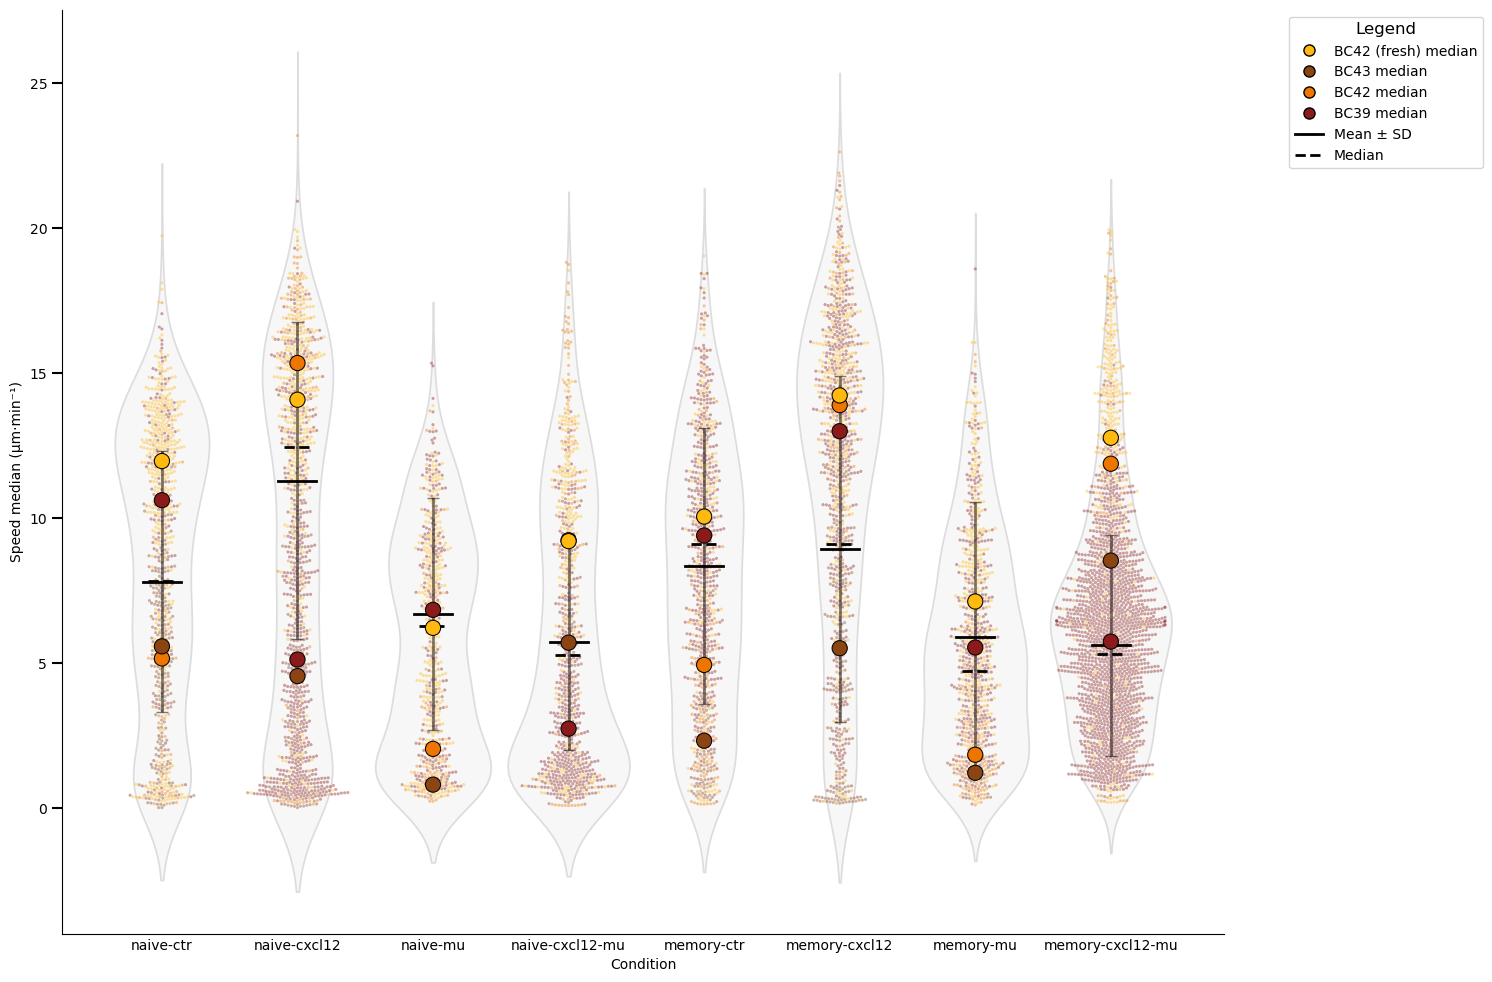

In [5]:
def SwarmPlot(
    df: pd.DataFrame,                                     
    metric: str,
    *args,
    title: str = '',
    palette: str = 'tab10',

    show_swarm: bool = True,
    swarm_size: int = 2.25,
    swarm_outline_color: str = 'black',
    swarm_alpha: float = 0.4,

    show_violin: bool = True, 
    violin_fill_color: str = 'whitesmoke', 
    violin_edge_color: str = 'lightgrey', 
    violin_alpha: float = 0.75,
    violin_outline_width: float = 1,

    show_mean: bool = True,
    mean_span: float = 0.14,
    mean_color: str = 'black',
    mean_ls: str = '-',
    show_median: bool = True,
    median_span: float = 0.10,
    median_color: str = 'black',
    line_width: float = 2,
    median_ls: str = '--',

    show_error_bars: bool = True,
    errorbar_capsize: int = 4,
    errorbar_color: str = 'black',
    errorbar_lw: int = 2,
    errorbar_alpha: float = 0.5,

    show_mean_balls: bool = False,
    mean_ball_size: int = 5,
    mean_ball_outline_color: str = 'black',
    mean_ball_outline_width: float = 0.75,
    mean_ball_alpha: int = 1,
    show_median_balls: bool = True,
    median_ball_size: int = 120,
    median_ball_outline_color: str = 'black',
    median_ball_outline_width: float = 0.75,
    median_ball_alpha: int = 1,

    show_kde: bool = False,
    kde_inset_width: float = 0.5,
    kde_outline: float = 1,
    kde_alpha: float = 0.5,
    kde_legend: bool = False,
    kde_fill: bool = False,

    p_test: bool = False,

    show_legend: bool = True,
    show_grid: bool = False,
    open_spine: bool = True,

    plot_width: int = 15,
    plot_height: int = 12,
):


    """
    **Swarmplot plotting function.**

    ## Parameters:
        **df**:
        Track DataFrame;
        **metric**:
        Column name of the desired metric;
        **palette**:
        Qualitative color palette differentiating replicates (default: 'tab10');
        **show_swarm**:
        Show individual tracks as swarm points (default: True);
        **swarm_size**:
        Size of the swarm points (default: 5); *Swarm point size is automatically adjusted if the points are overcrowded*;
        **swarm_outline_color**:
        (default: 'black');
        **swarm_alpha**:
        Swarm points transparency (default: 0.5);
        **show_violin**:
        (default: True);
        **violin_fill_color**:
        (default: 'whitesmoke');
        **violin_edge_color**:
        (default: 'lightgrey');
        **violin_alpha**:
        Violins transparency (default: 0.5);
        **violin_outline_width**:
        (default: 1);
        **show_mean**:
        Show condition mean as a line (default: True);
        **mean_span**:
        Span length of the mean line (default: 0.12);
        **mean_color**:
        (default: 'black');
        **show_median**:
        Show condition median as a line (default: True);
        **median_span**:
        Span length of the median line (default: 0.08);
        **median_color**:
        (default: 'black');
        **line_width**:
        Line width of mean and median lines (default: 1);
        **set_main_line**:
        Set whether to show mean or median as a full line, while showing the other as a dashed line (default: 'mean');
        **show_error_bars**:
        Show standard deviation error bars around the mean (default: True);
        **errorbar_capsize**:
        Span length of the errorbar caps (default: 4);
        **errorbar_color**:
        (default: 'black');
        **errorbar_lw**:
        Line width of the error bars (default: 1);
        **errorbar_alpha**:
        Transparency of the error bars (default: 0.5);
        **show_mean_balls**:
        Show replicate means (default: True);
        **mean_ball_size**:
        (default: 5);
        **mean_ball_outline_color**:
        (default: 'black');
        **mean_ball_outline_width**:
        (default: 0.75);
        **mean_ball_alpha**:
        (default: 1);
        **show_median_balls**:
        Show replicate medians (default: False);
        **median_ball_size**:
        (default: 5);
        **median_ball_outline_color**:
        (default: 'black');
        **median_ball_outline_width**:
        (default: 0.75);
        **median_ball_alpha**:
        (default: 1);
        **show_kde**:
        Show inset KDE plotted next to each condition for each replicate (default: False);
        **kde_inset_width**:
        Height of the inset KDE (default: 0.5);
        **kde_outline**:
        Line width of the KDE outline (default: 1);
        **kde_alpha**:
        Transparency of the KDE (default: 0.5);
        **kde_legend**:
        Show legend for the KDE plots (default: False);
        **kde_fill**:
        Fill the KDE plots (default: False);
        **p_test**:
        Perform Mann-Whitney U test between all conditions and annotate the plot with the p-values (default: False);
        **show_legend**:
        Show legend (default: True);
        **show_grid**:
        Show grid (default: False);
        **open_spine**:
        Don't show the top and right axes spines (default: True);
    """

    plt.figure(figsize=(plot_width, plot_height))
    ax = plt.gca()

    _df = df.copy()

    if _df.empty:
        return plt.gcf()
    

    # ---- replicate-aware palette pulled from df['Replicate color'] (with fallbacks) ----
    def _build_replicate_palette(df, palette_fallback):
        reps = df['Replicate'].unique().tolist()
        mp = {}
        if 'Replicate Color' in df.columns:
            mp = (df[['Replicate', 'Replicate Color']]
                    .dropna()
                    .drop_duplicates('Replicate')
            )
            mp = mp.set_index('Replicate')['Replicate Color'].to_dict()

        missing = [r for r in reps if r not in mp]
        if missing:
            cyc = sns.color_palette(palette_fallback, n_colors=len(missing))
            mp.update({r: cyc[i] for i, r in enumerate(missing)})

        return mp

    _palette = _build_replicate_palette(_df, palette_fallback=palette)

    # ------------------------------------------ Swarm plot -----------------------------------------------------------

    if show_swarm:
        sns.swarmplot(
            data=_df,
            x='Condition',
            y=metric,
            hue='Replicate',
            palette=_palette,
            size=swarm_size,
            edgecolor=swarm_outline_color,
            dodge=False,
            alpha=swarm_alpha,
            legend=False,
            zorder=2,
            ax=ax,
        )


    # ----------------------------------- Scatterplot of replicate means ------------------------------------------------------

    if show_mean_balls:
        replicate_means = _df.groupby(['Condition', 'Replicate'])[metric].mean().reset_index()
        sns.scatterplot(
            data=replicate_means, 
            x='Condition', 
            y=metric, 
            hue='Replicate', 
            palette=_palette, 
            edgecolor=mean_ball_outline_color, 
            s=mean_ball_size, 
            legend=False, 
            alpha=mean_ball_alpha, 
            linewidth=mean_ball_outline_width, 
            zorder=5
            )
    if show_median_balls:
        replicate_medians = _df.groupby(['Condition', 'Replicate'])[metric].median().reset_index()
        sns.scatterplot(
            data=replicate_medians, 
            x='Condition', 
            y=metric, 
            hue='Replicate', 
            palette=_palette, 
            edgecolor=median_ball_outline_color, 
            s=median_ball_size, 
            legend=False, 
            alpha=median_ball_alpha, 
            linewidth=median_ball_outline_width, 
            zorder=5
            )


    # -------------------------------------------- Violin plot ---------------------------------------------------------

    if show_violin:
        sns.violinplot(
            data=_df, 
            x='Condition', 
            y=metric, 
            color=violin_fill_color, 
            edgecolor=violin_edge_color if violin_edge_color else None, 
            width=violin_outline_width, 
            inner=None,
            gap=0.1, 
            alpha=violin_alpha, 
            zorder=1
            )
    

    #  ------------------------------------ Mean, median and errorbar lines -------------------------------------------

    condition_stats = _df.groupby('Condition')[metric].agg(['mean', 'median', 'std']).reset_index()
    for i, row in condition_stats.iterrows():
        x_center = i   # x coordinate
        if show_mean:
            sns.lineplot(
                x=[x_center - mean_span, x_center + mean_span], 
                y=[row['mean'], row['mean']], 
                color=mean_color, 
                linestyle=mean_ls, 
                linewidth=line_width, 
                label='Mean' if i == 0 else "", 
                zorder=4
                )
        
        if show_median:
            sns.lineplot(
                x=[x_center - median_span, x_center + median_span], 
                y=[row['median'], row['median']], 
                color=median_color, 
                linestyle=median_ls, 
                linewidth=line_width, 
                label='Median' if i == 0 else "", 
                zorder=4
                )
        
        if show_error_bars:
            plt.errorbar(
                x=x_center, 
                y=row['mean'], 
                yerr=row['std'], 
                fmt='None',
                color=errorbar_color, 
                alpha=errorbar_alpha, 
                linewidth=errorbar_lw, 
                capsize=errorbar_capsize, 
                zorder=4, 
                label='Mean ± SD' if i == 0 else ""
                )
        
    
    

    # ----------------------- Title settings ----------------------------

    # title = f"Swarm Plot"


    plt.title(title)
    plt.xlabel("Condition")
    plt.ylabel(f"{metric} (μm·min⁻¹)")

    if show_legend:
        handles, labels = [], []

        # Replicate entries
        for r in _df['Replicate'].astype(str).unique().tolist():
            c = _palette.get(r, 'grey')
            handles.append(mlines.Line2D([], [], linestyle='None',
                                        marker='o', markersize=8,
                                        markerfacecolor=c,
                                        markeredgecolor='black',
                                        label=(str(r) + " median")))
            labels.append(str(r) + " median")

        # Stats entries
        if show_mean and not show_error_bars:
            handles.append(mlines.Line2D([], [], color=mean_color,
                                        linestyle=mean_ls, linewidth=line_width,
                                        label='Mean'))
            labels.append('Mean')
        elif show_error_bars and not show_mean:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                        linestyle='-', linewidth=errorbar_lw,
                                        marker='_', markersize=10,
                                        label='SD'))
            labels.append('SD')
        elif show_mean and show_error_bars:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                        linestyle='-', linewidth=errorbar_lw,
                                        marker='_', markersize=10,
                                        label='Mean ± SD'))
            labels.append('Mean ± SD')
        if show_median:
            handles.append(mlines.Line2D([], [], color=median_color,
                                        linestyle=median_ls, linewidth=line_width,
                                        label='Median'))
            labels.append('Median')
        
            labels.append('Mean ± SD')

        ax.legend(handles, labels, title='Legend',
                title_fontsize=12, fontsize=10,
                loc='upper right', bbox_to_anchor=(1.15, 1),
                frameon=True)
        try:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except Exception:
            pass
    else:
        try:
            plt.legend().remove()
        except Exception:
            pass


    sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
    plt.tick_params(axis='y', which='major', length=7, width=1.5, direction='out', color='black')
    plt.tick_params(axis='x', which='major', length=0)
    if show_grid:
        plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)
    else:
        plt.grid(False)

    # Only move legend if it exists
    try:
        if plt.gca().get_legend() is not None:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
    except:
        try:
            ax = plt.gca()
            if plt.gca().get_legend() is not None:
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except:
            pass

    plt.savefig(f"Nela swarmplot ({metric}) {date.today()}.svg", format='svg', bbox_inches='tight')
    # return plt.gcf()

SwarmPlot(TRACKS_DATAFRAME, 'Speed median')

{'naive-ctr': 0, '__spacer_1__': 1, 'naive-cxcl12': 2, '__spacer_2__': 3, 'naive-mu': 4, '__spacer_3__': 5, 'naive-cxcl12-mu': 6, '__spacer_4__': 7, 'memory-ctr': 8, '__spacer_5__': 9, 'memory-cxcl12': 10, '__spacer_6__': 11, 'memory-mu': 12, '__spacer_7__': 13, 'memory-cxcl12-mu': 14}


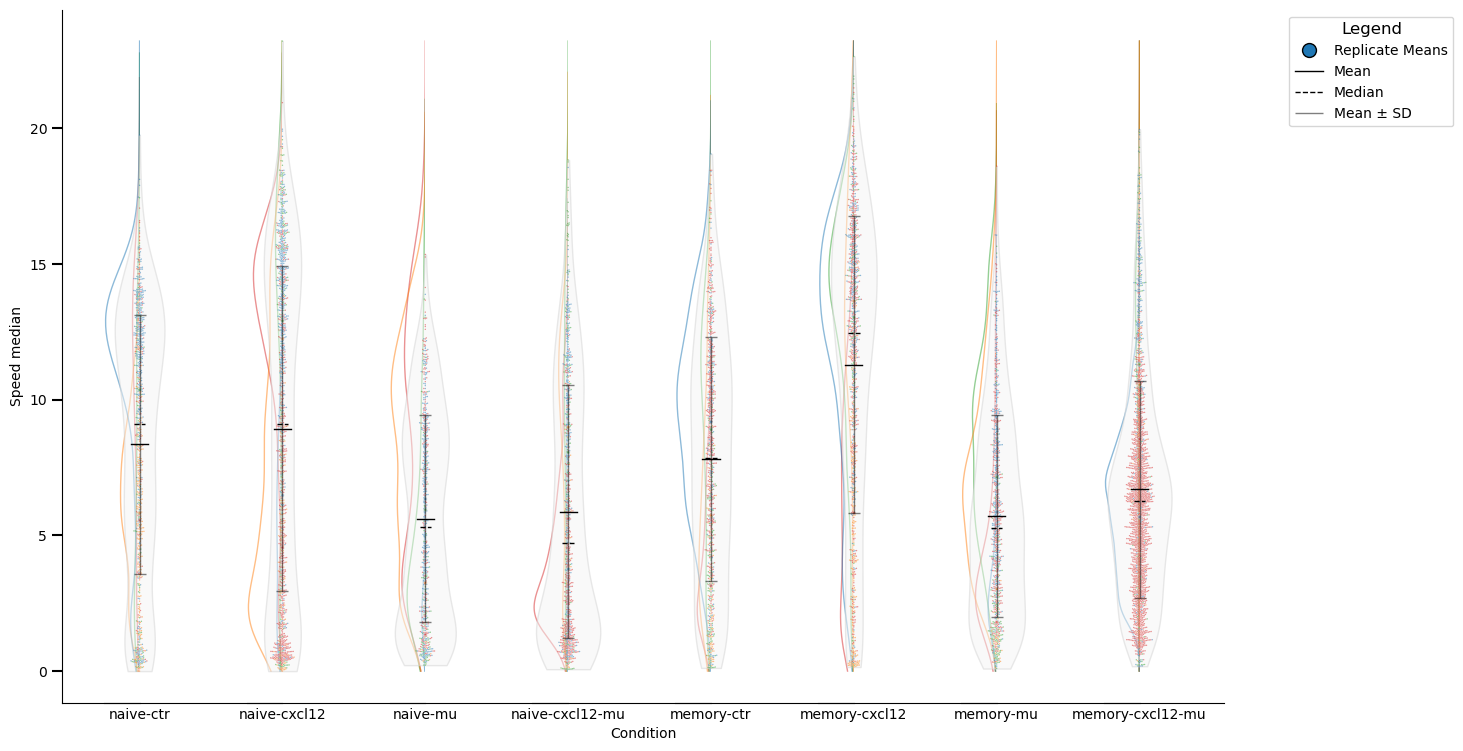

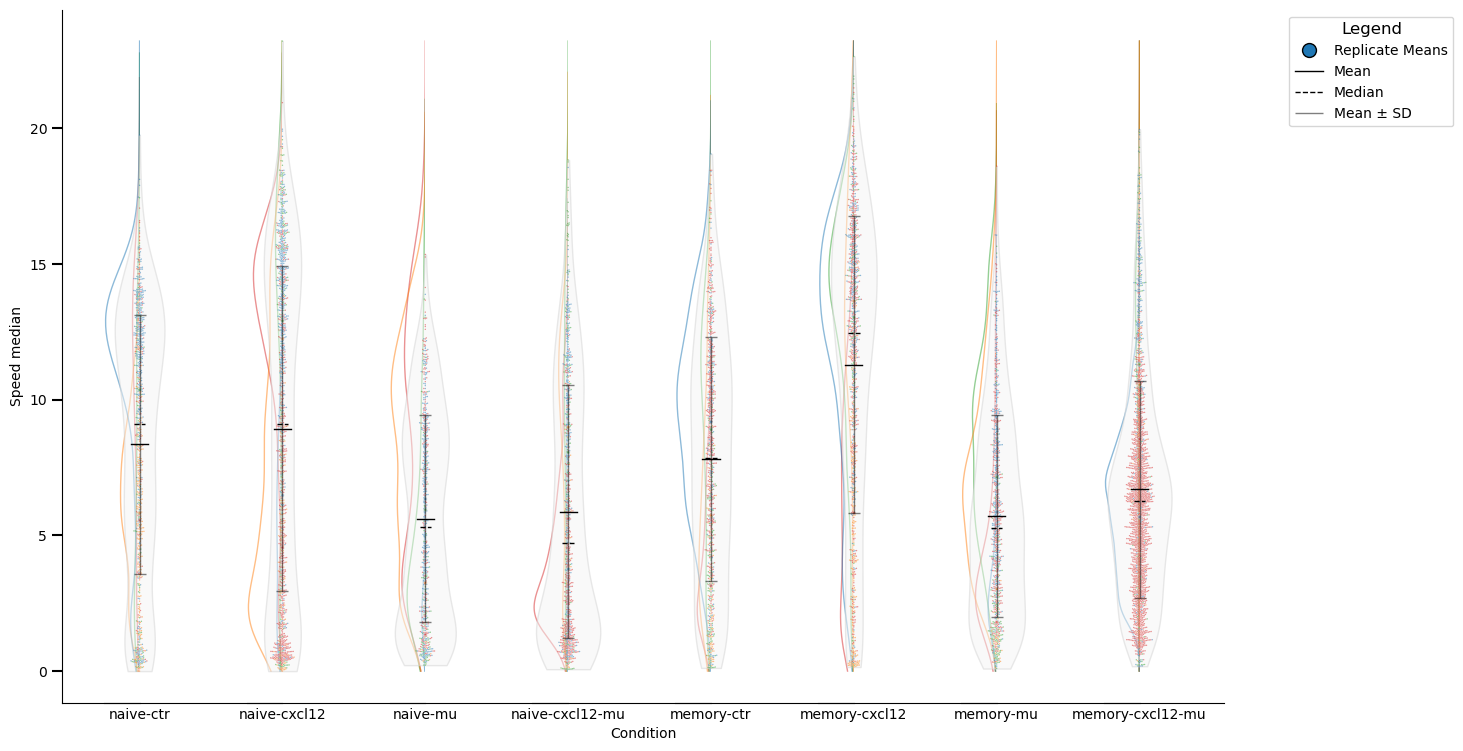

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from itertools import combinations
from scipy.stats import mannwhitneyu



def SwarmPlot(
    df: pd.DataFrame,
    metric: str,
    *args,
    title: str = '',
    palette: str = 'tab10',

    show_swarm: bool = True,
    swarm_size: int = 1,
    swarm_outline_color: str = 'black',
    swarm_alpha: float = 0.5,

    show_violin: bool = True,
    violin_fill_color: str = 'whitesmoke',
    violin_edge_color: str = 'lightgrey',
    violin_alpha: float = 0.5,
    violin_outline_width: float = 1,   # kept for API; mapped to linewidth on artists

    show_mean: bool = True,
    mean_span: float = 0.12,
    mean_color: str = 'black',
    show_median: bool = True,
    median_span: float = 0.08,
    median_color: str = 'black',
    line_width: float = 1,
    set_main_line: str = 'mean',

    show_error_bars: bool = True,
    errorbar_capsize: int = 4,
    errorbar_color: str = 'black',
    errorbar_lw: int = 1,
    errorbar_alpha: float = 0.5,

    show_mean_balls: bool = True,
    mean_ball_size: int = 5,
    mean_ball_outline_color: str = 'black',
    mean_ball_outline_width: float = 0.75,
    mean_ball_alpha: int = 1,
    show_median_balls: bool = False,
    median_ball_size: int = 5,
    median_ball_outline_color: str = 'black',
    median_ball_outline_width: float = 0.75,
    median_ball_alpha: int = 1,

    show_kde: bool = True,
    kde_inset_width: float = 0.5,
    kde_outline: float = 1,
    kde_alpha: float = 0.5,
    kde_legend: bool = False,
    kde_fill: bool = False,

    # NEW: precise spacing control for the KDE lane
    kde_pad: float = 0.5,          # padding between condition lane and KDE lane (in x data units)
    kde_lane_width: float = 0.42,   # how wide the KDE lane is inside the spacer (<= 0.5 recommended)

    p_test: bool = False,

    show_legend: bool = True,
    show_grid: bool = False,
    open_spine: bool = True,

    plot_width: int = 15,
    plot_height: int = 9,
):
    """
    **Swarmplot plotting function.**  (refactored for performance & clarity)

    Parameters preserved 1:1 with your original signature.
    """

    fig, ax = plt.subplots(figsize=(plot_width, plot_height))

    if df is None or df.empty:
        ax.set_title(title or "")
        ax.set_xlabel("Condition")
        ax.set_ylabel(metric)
        sns.despine(top=open_spine, right=open_spine, bottom=False, left=False, ax=ax)
        return fig

    # ---------- Prep (no in-place mutation of the caller's df) ----------
    _df = df.copy()
    # req('Condition' not in _df.columns and 'Replicate' in _df.columns and metric in _df.columns:)
        
    _df['Condition'] = _df['Condition'].astype(str)
    conditions = _df['Condition'].unique().tolist()

    hue = 'Replicate' if _df['Replicate'].nunique() > 1 else 'Condition'

    # Line styles
    mean_ls, median_ls = None, None
    if show_mean and show_median:
        if set_main_line == 'median':
            mean_ls, median_ls = '--', '-'
        else:
            mean_ls, median_ls = '-', '--'
    elif show_mean:
        mean_ls = '-'
    elif show_median:
        median_ls = '-'

    # Precompute stats once
    stats = (
        _df.groupby('Condition', observed=True)[metric]
            .agg(mean='mean', median='median', std='std', count='count')
            .reindex(conditions)
    )

    # ---------- Category order (optionally with spacers for KDE) ----------
    # ---------- Category order (with explicit spacer slots for KDE) ----------
    if show_kde:
        # `[cond0, spacer1, cond2, spacer3, ..., condN]` => conditions at even slots
        cat_order = []
        for i, c in enumerate(conditions):
            cat_order.append(c)
            if i < len(conditions) - 1:
                cat_order.append(f"__spacer_{i+1}__")
        _df['Condition'] = pd.Categorical(_df['Condition'], categories=cat_order, ordered=True)

        # positions: even integers for conditions, odd for spacers
        xpos = {cat: i for i, cat in enumerate(cat_order)}
        cond_slots = {c: xpos[c] for c in conditions}  # 0,2,4,...
    else:
        cat_order = conditions
        _df['Condition'] = pd.Categorical(_df['Condition'], categories=cat_order, ordered=True)
        xpos = {c: i for i, c in enumerate(cat_order)}
        cond_slots = xpos  # simple case

    print(xpos)

    # ---------- KDE insets (non-overlapping lane inside the spacer) ----------
    if show_kde:
        # hide spacer tick labels
        ax.set_xticks(range(len(cat_order)))
        ax.set_xticklabels([c if not str(c).startswith('__spacer_') else '' for c in cat_order])

        y_ax_min, y_ax_max = ax.get_ylim()
        y_span = (y_ax_max - y_ax_min)

        # for every condition at even slot k, its spacer (if any) is k+1
        for i, c in enumerate(conditions):
            slot = cond_slots[c]
            spacer = slot + 1
            # if it's the last condition, there's no spacer to the right; still draw inset using the
            # left-side part of its own lane (kept tidy with kde_pad)
            if spacer not in xpos:
                # fallback: occupy the left half inside the condition lane
                left = slot - 0.5 + kde_pad
                right = slot - 0.5 + kde_pad + min(kde_lane_width, 0.5 - kde_pad)
            else:
                # normal case: use the spacer lane entirely, with padding
                left_edge = spacer - 0.5
                right_edge = spacer + 0.5
                left = left_edge + kde_pad
                right = min(left + kde_lane_width, right_edge - kde_pad)

            # build inset in data coordinates (x from `left` to `right`, y full span)
            inset_ax = ax.inset_axes(
                [left, y_ax_min, right - left, y_span],
                transform=ax.transData, zorder=0, clip_on=True
            )

            g = _df[_df['Condition'] == c]
            if not g.empty:
                sns.kdeplot(
                    data=g, y=metric, hue=hue, fill=kde_fill, alpha=kde_alpha,
                    lw=kde_outline, palette=palette, ax=inset_ax, legend=kde_legend, zorder=0,
                    clip=(y_ax_min, y_ax_max)
                )

            inset_ax.invert_xaxis()        # keep the visual convention from your original
            inset_ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            sns.despine(ax=inset_ax, left=True, bottom=False, top=True, right=True)


    # ---------- Core drawers (shared by both branches) ----------
    def draw_swarm():
        sns.swarmplot(
            data=_df,
            x="Condition",
            y=metric,
            hue='Replicate',
            palette=palette,
            size=swarm_size,
            edgecolor=swarm_outline_color,
            dodge=False,
            alpha=swarm_alpha,
            legend=False,
            zorder=2,
            ax=ax,
        )

    def draw_violin():
        if not show_violin:
            return
        v = sns.violinplot(
            data=_df,
            x='Condition',
            y=metric,
            order=cat_order,
            color=violin_fill_color,
            inner=None,
            cut=0,
            bw_method='scott',
            linewidth=violin_outline_width if violin_edge_color else 0,
            width=0.9 if show_kde else 1.0,   # slightly narrower when KDE lane is present
            ax=ax,
            zorder=1
        )
        for coll in ax.collections:
            try:
                coll.set_alpha(violin_alpha)
                if violin_edge_color:
                    coll.set_edgecolor(violin_edge_color)
            except Exception:
                pass

        # Apply edgecolor & alpha on artists (robust to seaborn/mpl versions)
        for coll in ax.collections:
            try:
                coll.set_alpha(violin_alpha)
                if violin_edge_color:
                    coll.set_edgecolor(violin_edge_color)
            except Exception:
                pass

    def draw_replicate_points():
        # means
        if show_mean_balls:
            rep_means = (
                _df.groupby(['Condition', 'Replicate'], observed=True)[metric]
                    .mean()
                    .reset_index()
            )
            sns.scatterplot(
                data=rep_means,
                x='Condition',
                y=metric,
                hue=hue,
                palette=palette,
                edgecolor=mean_ball_outline_color,
                s=mean_ball_size,
                legend=False,
                alpha=mean_ball_alpha,
                linewidth=mean_ball_outline_width,
                zorder=4,
                ax=ax
            )
        # medians
        if show_median_balls:
            rep_meds = (
                _df.groupby(['Condition', 'Replicate'], observed=True)[metric]
                    .median()
                    .reset_index()
            )
            sns.scatterplot(
                data=rep_meds,
                x='Condition',
                y=metric,
                hue=hue,
                palette=palette,
                edgecolor=median_ball_outline_color,
                s=median_ball_size,
                legend=False,
                alpha=median_ball_alpha,
                linewidth=median_ball_outline_width,
                zorder=4,
                ax=ax
            )

    def draw_summary_lines_and_errors():
        for c in conditions:
            x = xpos[c]
            if show_mean:
                ax.plot([x - mean_span, x + mean_span],
                        [stats.at[c, 'mean'], stats.at[c, 'mean']],
                        color=mean_color, linestyle=mean_ls, linewidth=line_width, zorder=5,
                        label='Mean' if c == conditions[0] else None)
            if show_median:
                ax.plot([x - median_span, x + median_span],
                        [stats.at[c, 'median'], stats.at[c, 'median']],
                        color=median_color, linestyle=median_ls, linewidth=line_width, zorder=5,
                        label='Median' if c == conditions[0] else None)
            if show_error_bars:
                ax.errorbar(
                    x, stats.at[c, 'mean'], yerr=stats.at[c, 'std'],
                    fmt='None', color=errorbar_color, alpha=errorbar_alpha,
                    linewidth=errorbar_lw, capsize=errorbar_capsize, zorder=5,
                    label='Mean ± SD' if c == conditions[0] else None
                )

    # ---------- Draw main panels ----------
    if show_swarm:
        draw_swarm()

    draw_replicate_points()

    if show_violin:
        draw_violin()

    draw_summary_lines_and_errors()

    # ---------- P-tests ----------
    if p_test:
        real_conditions = conditions
        y_max = _df[metric].max()
        y_offset = y_max * 0.1
        for i, (c1, c2) in enumerate(combinations(real_conditions, 2)):
            d1 = _df.loc[_df['Condition'] == c1, metric]
            d2 = _df.loc[_df['Condition'] == c2, metric]
            _, pval = mannwhitneyu(d1, d2)
            x1, x2 = xpos[c1], xpos[c2]
            y = y_max + y_offset * (i + 1)
            ax.plot([x1, x1, x2, x2],
                    [y + 4.5, y + y_offset / 2.5, y + y_offset / 2.5, y + 1.5],
                    lw=1, color='black', zorder=6)
            ax.text((x1 + x2) / 2, y + y_offset / 2,
                    f'p = {pval:.3f}', ha='center', va='bottom', fontsize=10, color='black', zorder=6)

    # ---------- KDE insets (only extra work unique to KDE mode) ----------
    if show_kde:
        # Hide spacer tick labels
        ax.set_xticks(range(len(cat_order)))
        ax.set_xticklabels([c if not str(c).startswith('__spacer_') else '' for c in cat_order])

        y_ax_min, y_ax_max = ax.get_ylim()
        for c in conditions:
            g = _df[_df['Condition'] == c]
            if g.empty:
                continue
            x = xpos[c]
            # inset width in data coords, pinned left of the category
            inset_x0 = x - 0.5
            inset_height = (y_ax_max - y_ax_min)
            inset_ax = ax.inset_axes(
                [inset_x0, y_ax_min, kde_inset_width, inset_height],
                transform=ax.transData, zorder=0, clip_on=True
            )
            sns.kdeplot(
                data=g, y=metric, hue=hue, fill=kde_fill, alpha=kde_alpha,
                lw=kde_outline, palette=palette, ax=inset_ax, legend=kde_legend, zorder=0,
                clip=(y_ax_min, y_ax_max)
            )
            inset_ax.invert_xaxis()
            inset_ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            sns.despine(ax=inset_ax, left=True, bottom=False, top=True, right=True)

    # ---------- Labels, legend, cosmetics ----------
    ax.set_title(title)
    ax.set_xlabel("Condition")
    ax.set_ylabel(metric)

    # Build legend (robust)
    handles, labels = ax.get_legend_handles_labels()
    custom_handles = []
    custom_labels = []
    if show_mean_balls:
        custom_handles.append(
            mlines.Line2D([], [], marker='o', color='w',
                            markerfacecolor=sns.color_palette(palette)[0],
                            markeredgecolor=mean_ball_outline_color, markersize=10)
        )
        custom_labels.append('Replicate Means')
    if show_median_balls:
        custom_handles.append(
            mlines.Line2D([], [], marker='o', color='w',
                            markerfacecolor=sns.color_palette(palette)[0],
                            markeredgecolor=median_ball_outline_color, markersize=10)
        )
        custom_labels.append('Replicate Medians')

    handles = custom_handles + handles
    labels = custom_labels + labels

    if show_legend and (handles and labels):
        leg = ax.legend(handles=handles, labels=labels, title='Legend',
                        title_fontsize=12, fontsize=10, loc='upper right',
                        bbox_to_anchor=(1.15, 1), frameon=True)
        try:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except Exception:
            pass
    else:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    sns.despine(top=open_spine, right=open_spine, bottom=False, left=False, ax=ax)
    ax.tick_params(axis='y', which='major', length=7, width=1.5, direction='out', color='black')
    ax.tick_params(axis='x', which='major', length=0)
    ax.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2) if show_grid else ax.grid(False)

    return plt.gcf()


SwarmPlot(TRACKS_DATAFRAME, 'Speed median')


In [7]:
from itertools import chain

_df = TRACKS_DATAFRAME.copy()

conditions = TRACKS_DATAFRAME['Condition'].unique().tolist()

spaced_conditions = ["spacer_0"] + list(
    chain.from_iterable(
        (cond, f"spacer_{i+1}") if i < len(conditions) - 1 else (cond,)
        for i, cond in enumerate(conditions)
    )
)

_df['Condition'] = pd.Categorical(_df['Condition'], categories=spaced_conditions, ordered=True)


In [8]:
# ---- replicate-aware palette pulled from df['Replicate color'] (with fallbacks) ----
def _build_replicate_palette(df, palette_fallback):
    reps = df['Replicate'].unique().tolist()
    mp = {}
    if 'Replicate Color' in df.columns:
        mp = (df[['Replicate', 'Replicate Color']]
                .dropna()
                .drop_duplicates('Replicate')
        )
        mp = mp.set_index('Replicate')['Replicate Color'].to_dict()

    missing = [r for r in reps if r not in mp]
    if missing:
        cyc = sns.color_palette(palette_fallback, n_colors=len(missing))
        mp.update({r: cyc[i] for i, r in enumerate(missing)})

    return mp

    


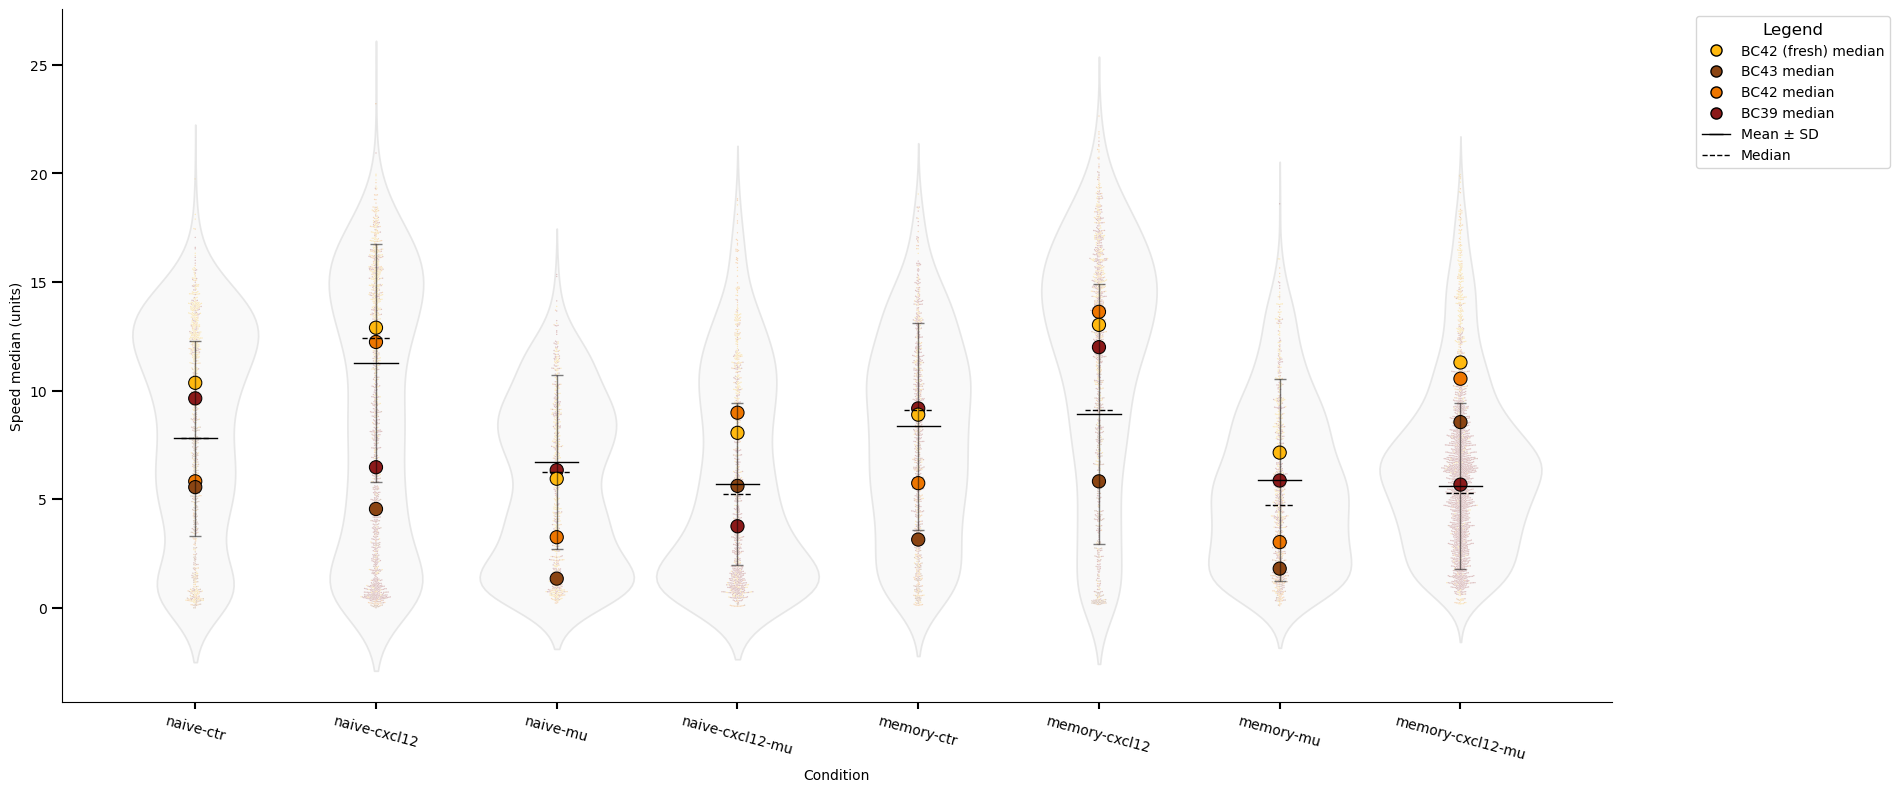

In [ ]:
from itertools  import chain

def SwarmPlot(
    df: pd.DataFrame,                                     
    metric: str,
    *args,
    title: str = '',
    palette: str = 'tab10',

    show_swarm: bool = True,
    swarm_size: int = 1,
    swarm_outline_color: str = 'black',
    swarm_alpha: float = 0.5,

    show_violin: bool = True, 
    violin_fill_color: str = 'whitesmoke', 
    violin_edge_color: str = 'lightgrey', 
    violin_alpha: float = 0.5,
    violin_outline_width: float = 1,

    show_mean: bool = True,
    mean_span: float = 0.12,
    mean_color: str = 'black',
    mean_ls: str = '-',
    show_median: bool = True,
    median_span: float = 0.08,
    median_color: str = 'black',
    median_ls: str = '--',
    line_width: float = 1,
    # set_main_line: str = 'mean',

    show_error_bars: bool = True,
    errorbar_capsize: int = 4,
    errorbar_color: str = 'black',
    errorbar_lw: int = 1,
    errorbar_alpha: float = 0.5,

    show_mean_balls: bool = True,
    mean_ball_size: int = 90,
    mean_ball_outline_color: str = 'black',
    mean_ball_outline_width: float = 0.75,
    mean_ball_alpha: int = 1,
    show_median_balls: bool = False,
    median_ball_size: int = 70,
    median_ball_outline_color: str = 'black',
    median_ball_outline_width: float = 0.75,
    median_ball_alpha: int = 1,

    show_kde: bool = False,
    kde_inset_width: float = 0.5,
    kde_outline: float = 1,
    kde_alpha: float = 0.5,
    kde_legend: bool = False,
    kde_fill: bool = False,

    p_test: bool = False,

    show_legend: bool = True,
    show_grid: bool = False,
    open_spine: bool = True,

    plot_width: int = 15,
    plot_height: int = 9,
):


    """
    **Swarmplot plotting function.**

    ## Parameters:
        **df**:
        Track DataFrame;
        **metric**:
        Column name of the desired metric;
        **palette**:
        Qualitative color palette differentiating replicates (default: 'tab10');
        **show_swarm**:
        Show individual tracks as swarm points (default: True);
        **swarm_size**:
        Size of the swarm points (default: 5); *Swarm point size is automatically adjusted if the points are overcrowded*;
        **swarm_outline_color**:
        (default: 'black');
        **swarm_alpha**:
        Swarm points transparency (default: 0.5);
        **show_violin**:
        (default: True);
        **violin_fill_color**:
        (default: 'whitesmoke');
        **violin_edge_color**:
        (default: 'lightgrey');
        **violin_alpha**:
        Violins transparency (default: 0.5);
        **violin_outline_width**:
        (default: 1);
        **show_mean**:
        Show condition mean as a line (default: True);
        **mean_span**:
        Span length of the mean line (default: 0.12);
        **mean_color**:
        (default: 'black');
        **show_median**:
        Show condition median as a line (default: True);
        **median_span**:
        Span length of the median line (default: 0.08);
        **median_color**:
        (default: 'black');
        **line_width**:
        Line width of mean and median lines (default: 1);
        **set_main_line**:
        Set whether to show mean or median as a full line, while showing the other as a dashed line (default: 'mean');
        **show_error_bars**:
        Show standard deviation error bars around the mean (default: True);
        **errorbar_capsize**:
        Span length of the errorbar caps (default: 4);
        **errorbar_color**:
        (default: 'black');
        **errorbar_lw**:
        Line width of the error bars (default: 1);
        **errorbar_alpha**:
        Transparency of the error bars (default: 0.5);
        **show_mean_balls**:
        Show replicate means (default: True);
        **mean_ball_size**:
        (default: 5);
        **mean_ball_outline_color**:
        (default: 'black');
        **mean_ball_outline_width**:
        (default: 0.75);
        **mean_ball_alpha**:
        (default: 1);
        **show_median_balls**:
        Show replicate medians (default: False);
        **median_ball_size**:
        (default: 5);
        **median_ball_outline_color**:
        (default: 'black');
        **median_ball_outline_width**:
        (default: 0.75);
        **median_ball_alpha**:
        (default: 1);
        **show_kde**:
        Show inset KDE plotted next to each condition for each replicate (default: False);
        **kde_inset_width**:
        Height of the inset KDE (default: 0.5);
        **kde_outline**:
        Line width of the KDE outline (default: 1);
        **kde_alpha**:
        Transparency of the KDE (default: 0.5);
        **kde_legend**:
        Show legend for the KDE plots (default: False);
        **kde_fill**:
        Fill the KDE plots (default: False);
        **p_test**:
        Perform Mann-Whitney U test between all conditions and annotate the plot with the p-values (default: False);
        **show_legend**:
        Show legend (default: True);
        **show_grid**:
        Show grid (default: False);
        **open_spine**:
        Don't show the top and right axes spines (default: True);
    """




    plt.figure(figsize=(plot_width, plot_height))
    ax = plt.gca()

    _df = df.copy()

    if df.empty:
        return plt.gcf()

    conditions = _df['Condition'].unique()

    _palette = _build_replicate_palette(_df, palette_fallback=palette)

    




    if show_kde:

        spaced_conditions = ["spacer_0"] + list(
            chain.from_iterable(
                (cond, f"spacer_{i+1}") if i < len(conditions) - 1 else (cond,)
                for i, cond in enumerate(conditions)
            )
        )

        _df['Condition'] = pd.Categorical(_df['Condition'], categories=spaced_conditions, ordered=True)

    _cond_stats = (
        _df.groupby('Condition', observed=False)[metric]
            .agg(mean='mean', median='median', std='std', count='count')
            .reset_index()
    )
    _rep_stats = (
        _df.groupby(['Condition', 'Replicate'], observed=False)[metric]
            .agg(mean='mean', median='median')
            .reset_index()
    )
            
        # ----------------------- Swarm plot --------------------------

    if show_swarm:
        sns.swarmplot(
            data=_df,
            x="Condition",
            y=metric,
            hue='Replicate',
            palette=_palette,
            size=swarm_size,
            edgecolor=swarm_outline_color,
            dodge=False,
            alpha=swarm_alpha,
            legend=False,
            zorder=2,
            ax=ax,
        )
                    
        

        # ------------------------ Violinplot -------------------------
    if show_violin:
        sns.violinplot(
            data=_df,
            x='Condition',
            y=metric,
            color=violin_fill_color,
            edgecolor=violin_edge_color if violin_edge_color else None,
            width=violin_outline_width,
            inner=None,
            gap=0.1, 
            alpha=violin_alpha, 
            zorder=2,
            )
        

        # ------------------------ Scatterplot of replicate means ------------------------------

        
    if show_mean_balls:
        sns.scatterplot(
            data=_rep_stats,
            x='Condition', 
            y='mean', 
            hue='Replicate', 
            palette=_palette, 
            edgecolor=mean_ball_outline_color, 
            s=mean_ball_size, 
            legend=False, 
            alpha=mean_ball_alpha, 
            linewidth=mean_ball_outline_width, 
            zorder=4
            )
    if show_median_balls:
        sns.scatterplot(
            data=_rep_stats, 
            x='Condition', 
            y='median', 
            hue='Replicate', 
            palette=_palette, 
            edgecolor=median_ball_outline_color, 
            s=median_ball_size, 
            legend=False, 
            alpha=median_ball_alpha, 
            linewidth=median_ball_outline_width, 
            zorder=4
            )
        

# ---------------------------- Mean, Meadian and Error bars --------------------------------

# condition_stats = df.groupby('Condition')[metric].agg(['mean', 'median', 'std']).reset_index()
    if show_kde:
        cond_num_list = list(range(len(conditions)*2)) 
    else:
        cond_num_list = list(range(len(conditions)))
    for cond in cond_num_list:

        x_center = cond_num_list[cond]  # Get the x position for the condition

        if show_mean:
            sns.lineplot(
                x=[x_center - mean_span, x_center + mean_span],
                y=[_cond_stats['mean'].loc[cond], _cond_stats['mean'].loc[cond]],
                color=mean_color, 
                linestyle=mean_ls, 
                linewidth=line_width,
                label='Mean' if cond == 0 else "", zorder=5
                )
            
        if show_median:
            sns.lineplot(
                x=[x_center - median_span, x_center + median_span],
                y=[_cond_stats['median'].loc[cond], _cond_stats['median'].loc[cond]],
                color=median_color, 
                linestyle=median_ls, 
                linewidth=line_width,
                label='Median' if cond == 0 else "", zorder=5
                )
            
        if show_error_bars:
            plt.errorbar(
                x_center, 
                _cond_stats['mean'].loc[cond], 
                yerr=_cond_stats['std'].loc[cond], 
                fmt='None',
                color=errorbar_color, 
                alpha=errorbar_alpha,
                linewidth=errorbar_lw, 
                capsize=errorbar_capsize, 
                zorder=5, 
                label='Mean ± SD' if cond == 0 else "",
                )
            

        if show_kde:
            
            # ------------------------ Dirty B.     ..ars ----------------------------
            # A dirty way to shift the x-axis positions and make room for the KDE plots

            for i in cond_num_list:
                x_val = cond_num_list[i]
                if i in _cond_stats.index:
                    sns.lineplot(
                        x=x_val-1,
                        y=[_cond_stats['median'].loc[i]],
                        color='white', 
                        linewidth=0,
                        label="", 
                        zorder=0
                        )


            # ------------------------ KDE inset plots ----------------------------

        
            y_ax_min, y_ax_max = ax.get_ylim()
            
            for cond in cond_num_list[::2]:
                group_df = _df[_df['Condition'] == conditions[cond // 2]]   # DataFrame group for a given condition

                y_max = group_df[metric].max()
                inset_height = y_ax_max * (y_max/y_ax_max) + abs(y_ax_min)   # height of the inset plot
                inset_y = y_ax_min   # y inset position

                x_val = cond_num_list[cond]  
                offset_x = 0.3

                inset_ax = ax.inset_axes([x_val - offset_x, inset_y, kde_inset_width, inset_height], transform=ax.transData, zorder=0, clip_on=True)
                
                sns.kdeplot(
                    data=group_df,
                    y=metric,
                    hue='Replicate',
                    fill=kde_fill,
                    alpha=kde_alpha,
                    lw=kde_outline,
                    palette=_palette,
                    ax=inset_ax,
                    legend=False,
                    zorder=0,
                    clip=(y_ax_min, y_ax_max),
                    # bw_method='scott'
                    )
                
                inset_ax.invert_xaxis()
                inset_ax.set_xticks([])
                inset_ax.set_yticks([])
                inset_ax.set_xlabel('')
                inset_ax.set_ylabel('')

                sns.despine(ax=inset_ax, left=True, bottom=True, top=True, right=True)



            # ------------------------ X axis clean-up ----------------------------
            # Another dirty trick - removing the spacer labels from the x-axis

                    
            ticks = [i for i, lbl in enumerate(spaced_conditions) if not str(lbl).startswith("spacer")]
            labels = [spaced_conditions[i] for i in ticks]
            plt.xticks(ticks=ticks, labels=labels)

        



    # ======================= IF FALSE KDE INSET =========================
    
    # if show_kde == False:

    #     # ------------------------------------------ Swarm plot -----------------------------------------------------------

    #     if show_swarm:
    #         ax = plt.gca()
    #         sns.swarmplot(
    #             data=df,
    #             x="Condition",
    #             y=metric,
    #             hue='Replicate',
    #             palette=palette,
    #             size=swarm_size,
    #             edgecolor=swarm_outline_color,
    #             dodge=False,
    #             alpha=swarm_alpha,
    #             legend=False,
    #             zorder=2,
    #             ax=ax,
    #         )


    #     # ----------------------------------- Scatterplot of replicate means ------------------------------------------------------

    #     if show_mean_balls:
    #         replicate_means = df.groupby(['Condition', 'Replicate'])[metric].mean().reset_index()
    #         sns.scatterplot(
    #             data=replicate_means, 
    #             x='Condition', 
    #             y=metric, 
    #             hue='Replicate', 
    #             palette=palette, 
    #             edgecolor=mean_ball_outline_color, 
    #             s=mean_ball_size, 
    #             legend=False, 
    #             alpha=mean_ball_alpha, 
    #             linewidth=mean_ball_outline_width, 
    #             zorder=4
    #             )
    #     if show_median_balls:
    #         replicate_medians = df.groupby(['Condition', 'Replicate'])[metric].median().reset_index()
    #         sns.scatterplot(
    #             data=replicate_medians, 
    #             x='Condition', 
    #             y=metric, 
    #             hue='Replicate', 
    #             palette=palette, 
    #             edgecolor=median_ball_outline_color, 
    #             s=median_ball_size, 
    #             legend=False, 
    #             alpha=median_ball_alpha, 
    #             linewidth=median_ball_outline_width, 
    #             zorder=4
    #             )


    #     # -------------------------------------------- Violin plot ---------------------------------------------------------

    #     if show_violin:
    #         sns.violinplot(
    #             data=df, 
    #             x='Condition', 
    #             y=metric, 
    #             color=violin_fill_color, 
    #             edgecolor=violin_edge_color if violin_edge_color else None, 
    #             width=violin_outline_width, 
    #             inner=None,
    #             gap=0.2, 
    #             alpha=violin_alpha, 
    #             zorder=1
    #             )
        

    #     #  ------------------------------------ Mean, median and errorbar lines -------------------------------------------

    #     condition_stats = df.groupby('Condition')[metric].agg(['mean', 'median', 'std']).reset_index()
    #     for i, row in condition_stats.iterrows():
    #         x_center = i   # x coordinate
    #         if show_mean:
    #             sns.lineplot(
    #                 x=[x_center - mean_span, x_center + mean_span], 
    #                 y=[row['mean'], row['mean']], 
    #                 color=mean_color, 
    #                 linestyle=mean_ls, 
    #                 linewidth=line_width, 
    #                 label='Mean' if i == 0 else "", 
    #                 zorder=4
    #                 )
            
    #         if show_median:
    #             sns.lineplot(
    #                 x=[x_center - median_span, x_center + median_span], 
    #                 y=[row['median'], row['median']], 
    #                 color=median_color, 
    #                 linestyle=median_ls, 
    #                 linewidth=line_width, 
    #                 label='Median' if i == 0 else "", 
    #                 zorder=4
    #                 )
            
    #         if show_error_bars:
    #             plt.errorbar(
    #                 x=x_center, 
    #                 y=row['mean'], 
    #                 yerr=row['std'], 
    #                 fmt='None',
    #                 color=errorbar_color, 
    #                 alpha=errorbar_alpha, 
    #                 linewidth=errorbar_lw, 
    #                 capsize=errorbar_capsize, 
    #                 zorder=5, 
    #                 label='Mean ± SD' if i == 0 else ""
    #                 )
            
        
    #     # ---------------------------------------- P-tests ------------------------------------------------------------

    #     if p_test:
    #         conditions = df['Condition'].unique()
    #         pairs = list(combinations(conditions, 2))
    #         y_max = df[metric].max()
    #         y_offset = (y_max * 0.1)  # Offset for p-value annotations
    #         for i, (cond1, cond2) in enumerate(pairs):
    #             data1 = df[df['Condition'] == cond1][metric]
    #             data2 = df[df['Condition'] == cond2][metric]
    #             stat, p_value = mannwhitneyu(data1, data2)
                
    #             # Annotate the plot with the p-value
    #             x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
    #             y = y_max + y_offset * (i + 1)
    #             plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
    #             plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')

        

    # ----------------------- Title settings ----------------------------

    # title = f"Swarm Plot"


    plt.title(title)
    plt.xlabel("Condition")
    plt.ylabel(f"{metric} (units)")

    if show_legend:
        handles, labels = [], []

        # Replicate entries
        for r in _df['Replicate'].astype(str).unique().tolist():
            c = _palette.get(r, 'grey')
            handles.append(mlines.Line2D([], [], linestyle='None',
                                        marker='o', markersize=8,
                                        markerfacecolor=c,
                                        markeredgecolor='black',
                                        label=(str(r) + " median")))
            labels.append(str(r) + " median")

        # Stats entries
        if show_mean and not show_error_bars:
            handles.append(mlines.Line2D([], [], color=mean_color,
                                        linestyle=mean_ls, linewidth=line_width,
                                        label='Mean'))
            labels.append('Mean')
        elif show_error_bars and not show_mean:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                        linestyle='-', linewidth=errorbar_lw,
                                        marker='_', markersize=10,
                                        label='SD'))
            labels.append('SD')
        elif show_mean and show_error_bars:
            handles.append(mlines.Line2D([], [], color=errorbar_color,
                                        linestyle='-', linewidth=errorbar_lw,
                                        marker='_', markersize=10,
                                        label='Mean ± SD'))
            labels.append('Mean ± SD')
        if show_median:
            handles.append(mlines.Line2D([], [], color=median_color,
                                        linestyle=median_ls, linewidth=line_width,
                                        label='Median'))
            labels.append('Median')
        
            labels.append('Mean ± SD')

        ax.legend(handles, labels, title='Legend',
                title_fontsize=12, fontsize=10,
                loc='upper right', bbox_to_anchor=(1.15, 1),
                frameon=True)
        try:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except Exception:
            pass
    else:
        try:
            plt.legend().remove()
        except Exception:
            pass

    sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
    plt.tick_params(axis='y', which='major', length=7, width=1.5, direction='out', color='black')
    plt.tick_params(axis='x', which='major', length=5, width=1.5, direction='out', color='black', rotation=330)
    if show_grid:
        plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)
    else:
        plt.grid(False)

    # Only move legend if it exists
    try:
        if plt.gca().get_legend() is not None:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
    except:
        try:
            ax = plt.gca()
            if plt.gca().get_legend() is not None:
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))
        except:
            pass

    # plt.savefig("plot.svg", format='svg', bbox_inches='tight')
    # return plt.gcf()

SwarmPlot(TRACKS_DATAFRAME, 'Speed median', show_kde=False, plot_width=20)